**Spatial Autocorrelation of Open Mobile Home Parks in El Monte, CA**

*Author: Paola Tirado*

This notebok explores the spatial autocorrelations of exisiting mobile home parks and demographics. The purpose is to go deeper into LA County and understand spatial trends in our data set and identify whether demographic trends are similiar in areas surronding exisiting mobile home parks. This analysis will be done at the Census block group level of El Monte, CA- the city within LA County with the most reported exisiting mobile home parks.

**Import Libraries**

In [4]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

In [7]:
# Race populations block group data from census reporter
mhp = gpd.read_file('data/acs2019_5yr_B03002_elmonte.geojson')

In [8]:
mhp_tracts = gpd.read_file('data/tracts.geojson')

<AxesSubplot:>

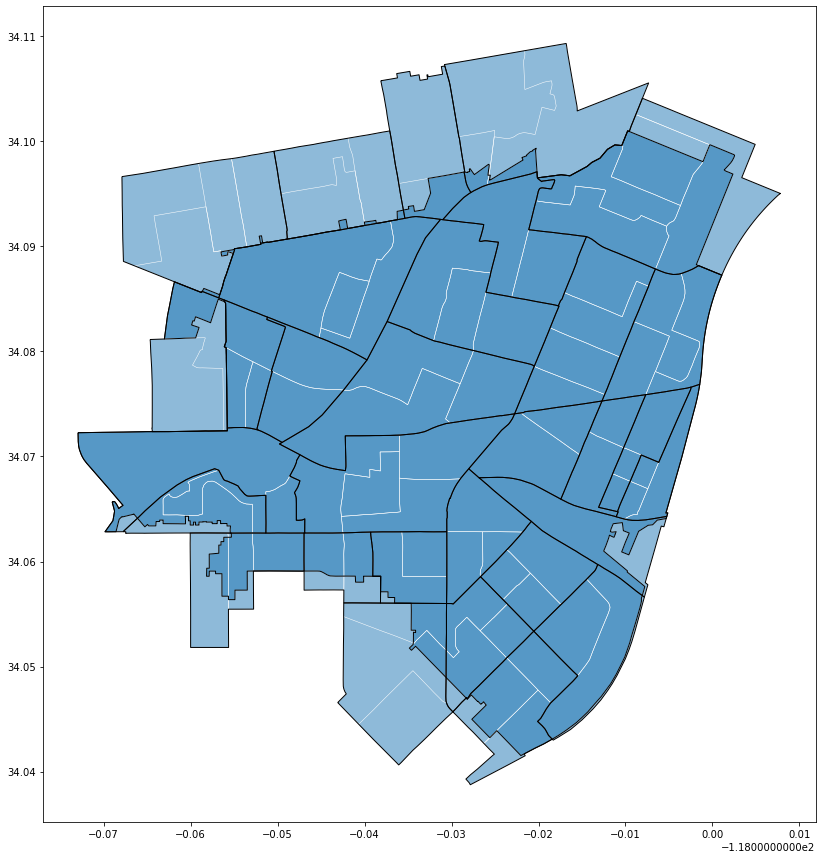

In [9]:
# compare
fig,ax = plt.subplots(figsize=(15,15))

# blue background of census tracts
mhp_tracts.plot(ax=ax,zorder=10,alpha=0.5)

# while lines to show block groups (sandwiched between the two layers above for visual clarity)
mhp.boundary.plot(ax=ax,color='white',zorder=15,lw=0.5)

# black boundary lines of census tracts on top of everything
mhp_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=1)

In [10]:
# total bounds
minx,miny,maxx,maxy = mhp.total_bounds

(34.238747000000004, 33.909327)

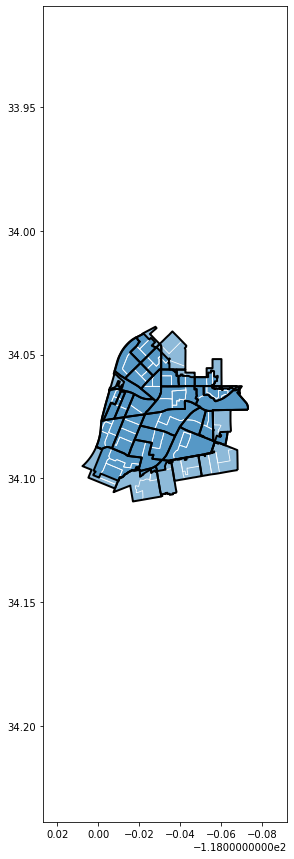

In [11]:
# compare
fig,ax = plt.subplots(figsize=(20,15))

# blue background of census tracts
mhp_tracts.plot(ax=ax,zorder=10,alpha=0.5)

# black boundary of census tracts
mhp_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=2)

# while lines to show block groups (sandwiched between the two layers above for visual clarity)
mhp.boundary.plot(ax=ax,color='white',zorder=15,lw=0.8)

# zoom in
ax.set_xlim(minx+0.1,maxx-0.1) # zooming in just a bit
ax.set_ylim(miny+0.2,maxy-0.2)

**Data Clean Up**

In [12]:
mhp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             79 non-null     object  
 1   name              79 non-null     object  
 2   B03002001         79 non-null     float64 
 3   B03002001, Error  79 non-null     float64 
 4   B03002002         79 non-null     float64 
 5   B03002002, Error  79 non-null     float64 
 6   B03002003         79 non-null     float64 
 7   B03002003, Error  79 non-null     float64 
 8   B03002004         79 non-null     float64 
 9   B03002004, Error  79 non-null     float64 
 10  B03002005         79 non-null     float64 
 11  B03002005, Error  79 non-null     float64 
 12  B03002006         79 non-null     float64 
 13  B03002006, Error  79 non-null     float64 
 14  B03002007         79 non-null     float64 
 15  B03002007, Error  79 non-null     float64 
 16  B03002008         79

In [13]:
# trim the data to the bare minimum columns
mhp = mhp[['geoid','B03002001','geometry']]

In [14]:
# rename the columns
mhp.columns = ['FIPS','TotalPop','geometry']

In [15]:
mhp.tail()

FIPS  TotalPop  \
74  15000US060374340012    2412.0   
75  15000US060374340031    1485.0   
76  15000US060374340032    1657.0   
77  15000US060374340033    1575.0   
78       16000US0622230  115517.0   

                                             geometry  
74  MULTIPOLYGON (((-118.01975 34.04506, -118.0195...  
75  MULTIPOLYGON (((-118.02985 34.04569, -118.0294...  
76  MULTIPOLYGON (((-118.02835 34.03929, -118.0278...  
77  MULTIPOLYGON (((-118.02365 34.05082, -118.0227...  
78  MULTIPOLYGON (((-118.07293 34.07227, -118.0728...

In [16]:
# delete last row which is for the entire city of El monte
mhp=mhp.drop(78)

In [17]:
# fix FIPS code
mhp['FIPS'] = mhp['FIPS'].str.replace('15000US','')
mhp.tail()

FIPS  TotalPop                                           geometry
73  060374340011    1998.0  MULTIPOLYGON (((-118.02054 34.05336, -118.0198...
74  060374340012    2412.0  MULTIPOLYGON (((-118.01975 34.04506, -118.0195...
75  060374340031    1485.0  MULTIPOLYGON (((-118.02985 34.04569, -118.0294...
76  060374340032    1657.0  MULTIPOLYGON (((-118.02835 34.03929, -118.0278...
77  060374340033    1575.0  MULTIPOLYGON (((-118.02365 34.05082, -118.0227...

Next, I'll get rid of census blocks groups with less than 20 total population. The reason why I am leaving the number so low is because based on research we know that MHP tend to be in areas not zoned residential- meaning that they are at times less dense areas. 

In [18]:
# sort by total pop
mhp.sort_values(by='TotalPop').head(20)

FIPS  TotalPop                                           geometry
51  060374333063     358.0  MULTIPOLYGON (((-118.01283 34.06567, -118.0125...
49  060374333061     611.0  MULTIPOLYGON (((-118.01132 34.06868, -118.0113...
35  060374329021     721.0  MULTIPOLYGON (((-118.06264 34.08343, -118.0624...
53  060374333072     736.0  MULTIPOLYGON (((-118.01104 34.06432, -118.0109...
70  060374339021     772.0  MULTIPOLYGON (((-118.02607 34.05393, -118.0254...
41  060374332002     835.0  MULTIPOLYGON (((-118.04267 34.06429, -118.0424...
0   060374315011     857.0  MULTIPOLYGON (((-118.03607 34.09599, -118.0357...
2   060374315023     881.0  MULTIPOLYGON (((-118.02916 34.10046, -118.0279...
56  060374334012     942.0  MULTIPOLYGON (((-118.04696 34.06034, -118.0469...
54  060374333073     956.0  MULTIPOLYGON (((-118.00913 34.06828, -118.0091...
63  060374335042     991.0  MULTIPOLYGON (((-118.05289 34.06222, -118.0528...
72  060374339023    1021.0  MULTIPOLYGON (((-118.03061 34.05173, -118.0305...
40  060374332001    1039.0  MULTIPOLYGON (((-118.03599 34.07204, -118.0359...
30  060374328011    1068.0  MULTIPOLYGON (((-118.05119 34.08317, -118.0511...
28  060374327002    1126.0  MULTIPOLYGON (((-118.04977 34.07119, -118.0494...
1   060374315022    1134.0  MULTIPOLYGON (((-118.02589 34.09595, -118.0258...
33  060374328022    1137.0  MULTIPOLYGON (((-118.05590 34.08036, -118.0557...
36  060374331011    1167.0  MULTIPOLYGON (((-118.05135 34.06562, -118.0513...
9   060374323002    1176.0  MULTIPOLYGON (((-118.04489 34.08286, -118.0448...
69  060374339013    1200.0  MULTIPOLYGON (((-118.02667 34.05855, -118.0261...

In [19]:
# delete less than 100 population geographies
mhp = mhp[mhp['TotalPop']>20]

**Census Blocks**

In [20]:
# get the layers into a web mercator projection
# reproject to web mercator
mhp = mhp.to_crs(epsg=3857)

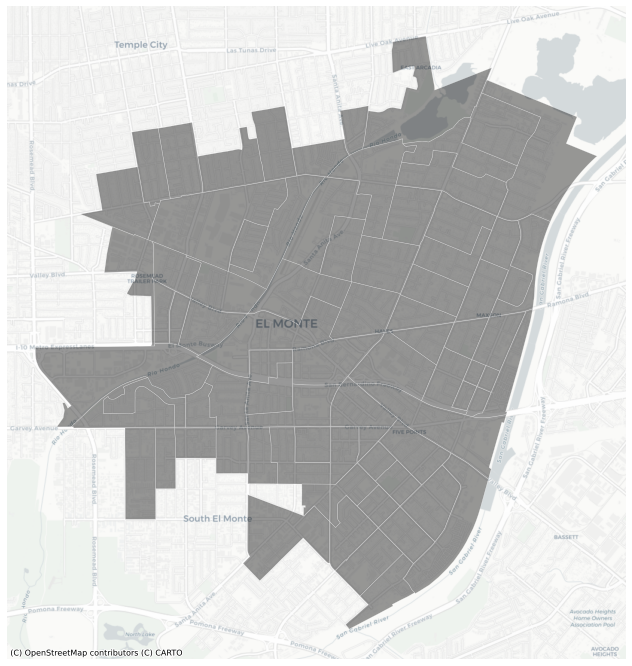

In [21]:
# plot it!
fig, ax = plt.subplots(figsize=(12,12))

mhp.plot(ax=ax,
         color='black', 
         edgecolor='white',
         lw=0.5,
         alpha=0.4)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

**Bringing in Open Mobile Home Park Data**

In [22]:
open = gpd.read_file('data/MHP_geocoded.geojson')

In [23]:
open.shape

(374, 16)

In [24]:
open.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Park Name           374 non-null    object  
 1   County              374 non-null    object  
 2   Park Identifier     374 non-null    object  
 3   Park Address        374 non-null    object  
 4   City                374 non-null    object  
 5   Zip                 374 non-null    object  
 6   Phone               367 non-null    object  
 7   Fire Authority      374 non-null    object  
 8   Jurisdiction        374 non-null    object  
 9   MH Spaces           374 non-null    int64   
 10  RV Lots W/Drains    374 non-null    int64   
 11  RV Lots W/O Drains  374 non-null    int64   
 12  Operated by         374 non-null    object  
 13  lat                 374 non-null    float64 
 14  lon                 374 non-null    float64 
 15  geometry            374 non-null

**Trimming Data for El Monte**

In [25]:
open.City.value_counts()

 EL MONTE         29
 LANCASTER        22
 BELLFLOWER       20
 GARDENA          20
 POMONA           15
                  ..
 LYNWOOD           1
 LAKEWOOD          1
 SANTA MONICA      1
 MONTEREY PARK     1
 WEST COVINA       1
Name: City, Length: 74, dtype: int64

In [51]:
open['total units'] = open['MH Spaces'] +open['RV Lots W/Drains'] + open['RV Lots W/O Drains']
open.head()

Park Name       County Park Identifier  \
0      CHETS TRAILER PARK  LOS ANGELES      19-0001-MP   
1        ACE TRAILER PARK  LOS ANGELES      19-0006-MP   
2                ACORN TP  LOS ANGELES      19-0009-MP   
3  AZUSA MOBILE HOME PARK  LOS ANGELES      19-0039-MP   
4     CULVER CITY TERRACE  LOS ANGELES      19-0044-MP   

                                  Park Address           City    Zip  \
0  4630 W ROSECRANS AVE ,  LAWNDALE,  CA 90260       LAWNDALE  90260   
1   6508 FLORENCE PL,  BELL GARDENS,  CA 90201   BELL GARDENS  90201   
2        2818 DURFEE AVE,  EL MONTE,  CA 91732       EL MONTE  91732   
3           812 N LOREN AVE,  AZUSA,  CA 91702          AZUSA  91702   
4      11250 PLAYA ST,  CULVER CITY,  CA 90230    CULVER CITY  90230   

             Phone                                     Fire Authority  \
0   (310) 676-0663  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
1   (213) 927-2868  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
2   (818) 350-5235  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
3   (626) 334-2306  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
4   (213) 398-3761  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...   

                                        Jurisdiction  MH Spaces  \
0  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...         49   
1  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...          8   
2  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...         20   
3  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...         46   
4  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...        117   

   RV Lots W/Drains  RV Lots W/O Drains  \
0                 0                   0   
1                 0                   0   
2                 0                   0   
3                 0                   0   
4                 0                   0   

                                         Operated by        lat         lon  \
0  DOSHI, NAVINCHANDRA, 6418 SPRING PARK AVE, LOS...  33.901817 -118.357847   
1  LUELLA PERDEW REVOCABLE TRUST, PO BOX 3259, WI...  33.966128 -118.149340   
2  PATTERSON, GLEN, PO BOX 1811, MYRTLE CREEK, OR...  34.056116 -118.017002   
3  KENDALL AZUSA COMMUNITIES LLC, 17300 RED HILL ...  34.136405 -117.923652   
4  CULVER CITY MOBILEHOME OWNERS ASSOCIATION, C/O...  33.992145 -118.391855   

                      geometry  total  total units  
0  POINT (-118.35785 33.90182)     49           49  
1  POINT (-118.14934 33.96613)      8            8  
2  POINT (-118.01700 34.05612)     20           20  
3  POINT (-117.92365 34.13640)     46           46  
4  POINT (-118.39186 33.99215)    117          117

In [52]:
elmonte = open.City.value_counts().head(1).index.tolist()
elmonte

[' EL MONTE']

In [53]:
monte = open[open['City']== ' EL MONTE']
monte.shape

(29, 18)

In [54]:
monte.head()

Park Name       County Park Identifier  \
2               ACORN TP  LOS ANGELES      19-0009-MP   
6      BEL AIRE MH LODGE  LOS ANGELES      19-0051-MP   
9          SHADY LANE MP  LOS ANGELES      19-0079-MP   
27             FELIPE TP  LOS ANGELES      19-0218-MP   
33  VICTORY TRAILER PARK  LOS ANGELES      19-0263-MP   

                                   Park Address       City    Zip  \
2         2818 DURFEE AVE,  EL MONTE,  CA 91732   EL MONTE  91732   
6      2336 LEXINGTON AVE,  EL MONTE,  CA 91731   EL MONTE  91731   
9   2532 MOUNTAIN VIEW RD,  EL MONTE,  CA 91731   EL MONTE  91731   
27        12328 FELIPE ST,  EL MONTE,  CA 91732   EL MONTE  91732   
33       11208 GARVEY AVE,  EL MONTE,  CA 91731   EL MONTE  91731   

              Phone                                     Fire Authority  \
2    (818) 350-5235  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
6    (310) 444-6411  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
9    (213) 585-8782  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
27   (818) 448-5849  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
33   (213) 539-2582  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   

                                         Jurisdiction  MH Spaces  \
2   HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...         20   
6   HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...         34   
9   HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...         20   
27  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...         11   
33  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...          3   

    RV Lots W/Drains  RV Lots W/O Drains  \
2                  0                   0   
6                  0                   0   
9                  0                   0   
27                 0                   0   
33                 0                   0   

                                          Operated by        lat         lon  \
2   PATTERSON, GLEN, PO BOX 1811, MYRTLE CREEK, OR...  34.056116 -118.017002   
6   WONG ASSOCIATES, 444 S FLOWER ST, LOS ANGELES,...  34.059182 -118.038944   
9   GHUMAN, DASH, 2532 MOUNTAIN VIEW RD, EL MONTE,...  34.057399 -118.027922   
27  HUANG, CHU, 2440 S HACIENDA BLVD #132, HACIEND...  34.051500 -118.021539   
33  JACKSON, CHOW, 3112 SEAMAN AVE, EL MONTE, CA 9...  34.062747 -118.031829   

                       geometry  total  total units  
2   POINT (-118.01700 34.05612)     20           20  
6   POINT (-118.03894 34.05918)     34           34  
9   POINT (-118.02792 34.05740)     20           20  
27  POINT (-118.02154 34.05150)     11           11  
33  POINT (-118.03183 34.06275)      3            3

In [55]:
# convert pandas dataframe to geodataframe
monte = gpd.GeoDataFrame(monte, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(monte.lon, monte.lat))

In [56]:
# get the layers into a web mercator projection
# reproject to web mercator
monte = monte.to_crs(epsg=3857)

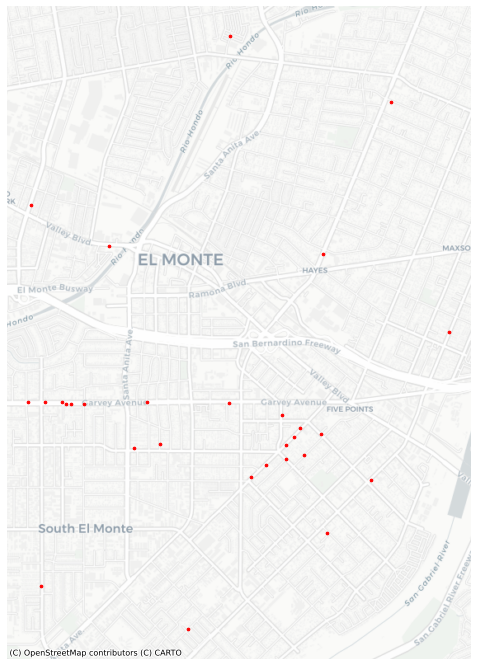

In [57]:
# map it!
fig,ax = plt.subplots(figsize=(12,12))

monte.plot(ax=ax,
             color='red',
             markersize=7)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

**

**Create two layer map**

In [58]:
# get the bounding box coordinates for the El Monte MHP data
minx, miny, maxx, maxy = monte.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13141568.495397476
-13136683.65507837
4034606.530889119
4041486.038246411


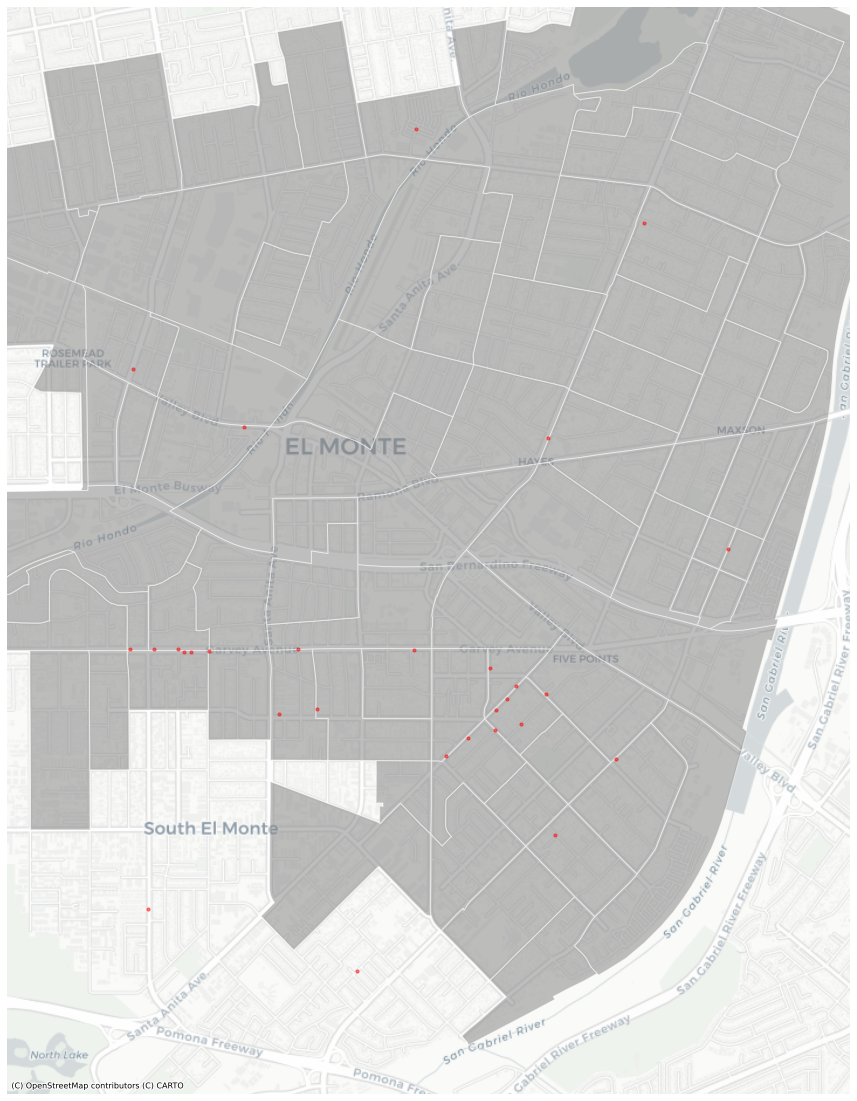

In [59]:
# set up the plot canvas with plt.subplots
fig, ax = plt.subplots(figsize=(20, 20))

# block groups
mhp.plot(ax=ax, # this puts it in the ax plot
        color='gray', 
        edgecolor='white',
        alpha=0.5)

# arrests
monte.plot(ax=ax, # this also puts it in the same ax plot
            color='red',
            markersize=10,
            alpha=0.5)

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

**Spatial Join**

In [60]:
# Do the spatial join
join = gpd.sjoin(monte, mhp, how='left')
join.head()

Park Name       County Park Identifier  \
2               ACORN TP  LOS ANGELES      19-0009-MP   
6      BEL AIRE MH LODGE  LOS ANGELES      19-0051-MP   
9          SHADY LANE MP  LOS ANGELES      19-0079-MP   
27             FELIPE TP  LOS ANGELES      19-0218-MP   
33  VICTORY TRAILER PARK  LOS ANGELES      19-0263-MP   

                                   Park Address       City    Zip  \
2         2818 DURFEE AVE,  EL MONTE,  CA 91732   EL MONTE  91732   
6      2336 LEXINGTON AVE,  EL MONTE,  CA 91731   EL MONTE  91731   
9   2532 MOUNTAIN VIEW RD,  EL MONTE,  CA 91731   EL MONTE  91731   
27        12328 FELIPE ST,  EL MONTE,  CA 91732   EL MONTE  91732   
33       11208 GARVEY AVE,  EL MONTE,  CA 91731   EL MONTE  91731   

              Phone                                     Fire Authority  \
2    (818) 350-5235  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
6    (310) 444-6411  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
9    (213) 585-8782  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
27   (818) 448-5849  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
33   (213) 539-2582  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   

                                         Jurisdiction  MH Spaces  ...  \
2   HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...         20  ...   
6   HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...         34  ...   
9   HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...         20  ...   
27  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...         11  ...   
33  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...          3  ...   

    RV Lots W/O Drains                                        Operated by  \
2                    0  PATTERSON, GLEN, PO BOX 1811, MYRTLE CREEK, OR...   
6                    0  WONG ASSOCIATES, 444 S FLOWER ST, LOS ANGELES,...   
9                    0  GHUMAN, DASH, 2532 MOUNTAIN VIEW RD, EL MONTE,...   
27                   0  HUANG, CHU, 2440 S HACIENDA BLVD #132, HACIEND...   
33                   0  JACKSON, CHOW, 3112 SEAMAN AVE, EL MONTE, CA 9...   

          lat         lon                           geometry total  \
2   34.056116 -118.017002  POINT (-13137592.525 4036339.550)    20   
6   34.059182 -118.038944  POINT (-13140035.153 4036751.510)    34   
9   34.057399 -118.027922  POINT (-13138808.155 4036511.883)    20   
27  34.051500 -118.021539  POINT (-13138097.624 4035719.271)    11   
33  34.062747 -118.031829  POINT (-13139243.118 4037230.473)     3   

    total units  index_right          FIPS TotalPop  
2            20         73.0  060374340011   1998.0  
6            34         58.0  060374334022   2762.0  
9            20         72.0  060374339023   1021.0  
27           11         77.0  060374340033   1575.0  
33            3         57.0  060374334021   1951.0  

[5 rows x 21 columns]

This creates a dataframe wiht every mhp in El Montye with the corresponding FIPS code. Since I know from past analysis that most units are mobile homes, next I'll create another dataframe that counts mobile home units by their corresponding block groups. 

In [62]:
mh_by_gdf = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='MH SPACES')

In [63]:
mh_by_gdf.head()

FIPS  MH SPACES
0  060374339013          3
1  060374334033          2
2  060374339023          2
3  060374331011          2
4  060374335042          2

<AxesSubplot:xlabel='FIPS'>

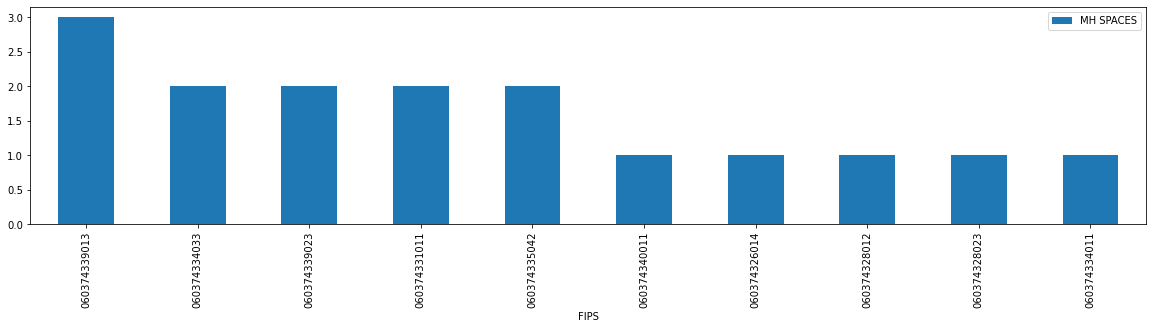

In [64]:
# make a bar chart of top 10 parks
mh_by_gdf[:10].plot.bar(figsize=(20,4),
                             x='FIPS',
                             y='MH SPACES')

Now, we know this bar graph isn't as informative as it can be. I'll be merginging the counts back to 'mhp' , the block group gdf.

In [66]:
# join the summary table back to the gdf
mhp=mhp.merge(mh_by_gdf,on='FIPS')

In [68]:
mhp.head()

FIPS  TotalPop                                           geometry  \
0  060374315011     857.0  MULTIPOLYGON (((-13139714.874 4041698.432, -13...   
1  060374326014    1814.0  MULTIPOLYGON (((-13137541.806 4040432.328, -13...   
2  060374327001    3177.0  MULTIPOLYGON (((-13139101.837 4038718.964, -13...   
3  060374328012    1729.0  MULTIPOLYGON (((-13141525.930 4038571.671, -13...   
4  060374328023    1975.0  MULTIPOLYGON (((-13141954.177 4040210.415, -13...   

   MH SPACES  
0          1  
1          1  
2          1  
3          1  
4          1

Now my neighborhood table has a count column.

**Normalizinng Mobile Homes per 1000 people**

Normalizing the data by the number of people who live in the census block.

In [72]:
mhp['mh_per_1000'] = mhp['MH SPACES']/mhp['TotalPop']*1000

In [73]:
mhp.sort_values(by="mh_per_1000").tail()

FIPS  TotalPop                                           geometry  \
8   060374333061     611.0  MULTIPOLYGON (((-13136959.828 4038027.670, -13...   
5   060374331011    1167.0  MULTIPOLYGON (((-13141415.947 4037617.268, -13...   
18  060374339023    1021.0  MULTIPOLYGON (((-13139107.181 4035750.084, -13...   
15  060374335042     991.0  MULTIPOLYGON (((-13141588.047 4037159.312, -13...   
17  060374339013    1200.0  MULTIPOLYGON (((-13138669.361 4036666.573, -13...   

    MH SPACES  mh_per_1000  
8           1     1.636661  
5           2     1.713796  
18          2     1.958864  
15          2     2.018163  
17          3     2.500000

Let's map the top 10 geographies to get a visual of what our data looks like

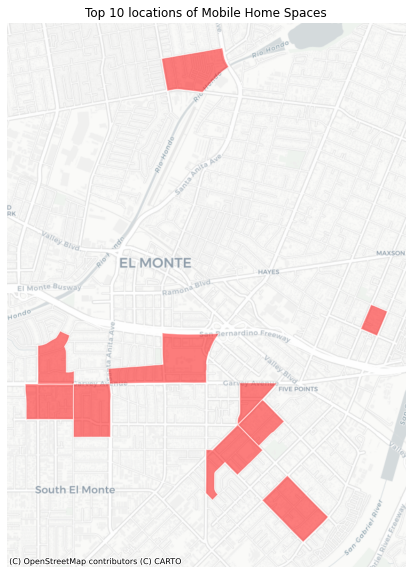

In [74]:
# map the top 10 geographies
fig,ax = plt.subplots(figsize=(12,10))
mhp.sort_values(by='mh_per_1000',ascending=False)[:10].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('Top 10 locations of Mobile Home Spaces')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

**Choropleth map of mobile homes**

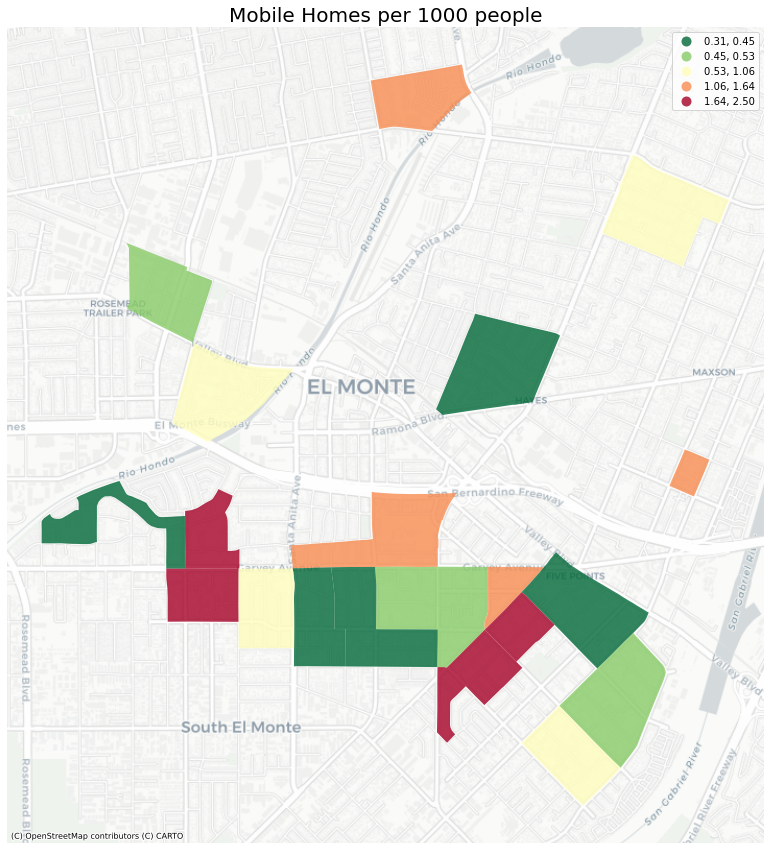

In [75]:
fig,ax = plt.subplots(figsize=(15,15))

mhp.plot(ax=ax,
        column='mh_per_1000',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles')

ax.axis('off')
ax.set_title('Mobile Homes per 1000 people',fontsize=20)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

This map is important because we begin to see clusters of mobile home parks based on populations. This can help us explore if mobile homes are in more of less dense areas.

**Spatial Autocorreltion**

In [77]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(mhp,k=8)

# Row-standardization
wq.transform = 'r'

**Spatial Lag**

In [78]:
# create a new column for the spatial lag
mhp['mh_per_1000_lag'] = lps.weights.lag_spatial(wq, mhp['mh_per_1000'])

In [79]:
mhp.sample(10)[['FIPS','TotalPop','MH SPACES','mh_per_1000','mh_per_1000_lag']]
# this tells me that if the mobile home (mh) per 1000 is close or similar in value to spatial lag, the block group is more similar to it's 8 closes neighrbors.

FIPS  TotalPop  MH SPACES  mh_per_1000  mh_per_1000_lag
2   060374327001    3177.0          1     0.314762         1.070342
8   060374333061     611.0          1     1.636661         0.998755
6   060374331022    2229.0          1     0.448632         0.980487
1   060374326014    1814.0          1     0.551268         1.122567
15  060374335042     991.0          2     2.018163         0.785074
14  060374334033    1518.0          2     1.317523         0.984838
20  060374340033    1575.0          1     0.634921         0.999828
13  060374334032    1888.0          1     0.529661         1.071509
19  060374340011    1998.0          1     0.500501         1.175956
0   060374315011     857.0          1     1.166861         0.977039

In [80]:
# create a column that calculates the difference betwen mobile homes and lag
mhp['mh_lag_diff'] = mhp['mh_per_1000'] - mhp['mh_per_1000_lag']

In [81]:
# output to get the head and tail
mhp.sort_values(by='mh_lag_diff')

FIPS  TotalPop                                           geometry  \
16  060374339011    3150.0  MULTIPOLYGON (((-13138334.067 4037009.351, -13...   
12  060374334022    2762.0  MULTIPOLYGON (((-13140074.881 4037238.458, -13...   
9   060374334011    2463.0  MULTIPOLYGON (((-13140428.209 4037228.246, -13...   
2   060374327001    3177.0  MULTIPOLYGON (((-13139101.837 4038718.964, -13...   
19  060374340011    1998.0  MULTIPOLYGON (((-13137986.416 4035969.760, -13...   
11  060374334021    1951.0  MULTIPOLYGON (((-13139675.244 4037241.683, -13...   
1   060374326014    1814.0  MULTIPOLYGON (((-13137541.806 4040432.328, -13...   
4   060374328023    1975.0  MULTIPOLYGON (((-13141954.177 4040210.415, -13...   
13  060374334032    1888.0  MULTIPOLYGON (((-13139100.724 4036496.598, -13...   
6   060374331022    2229.0  MULTIPOLYGON (((-13142730.296 4037641.591, -13...   
3   060374328012    1729.0  MULTIPOLYGON (((-13141525.930 4038571.671, -13...   
20  060374340033    1575.0  MULTIPOLYGON (((-13138333.065 4035628.357, -13...   
7   060374332002     835.0  MULTIPOLYGON (((-13140450.028 4037437.604, -13...   
10  060374334012     942.0  MULTIPOLYGON (((-13140927.366 4036907.498, -13...   
0   060374315011     857.0  MULTIPOLYGON (((-13139714.874 4041698.432, -13...   
14  060374334033    1518.0  MULTIPOLYGON (((-13138671.587 4036728.517, -13...   
8   060374333061     611.0  MULTIPOLYGON (((-13136959.828 4038027.670, -13...   
5   060374331011    1167.0  MULTIPOLYGON (((-13141415.947 4037617.268, -13...   
18  060374339023    1021.0  MULTIPOLYGON (((-13139107.181 4035750.084, -13...   
15  060374335042     991.0  MULTIPOLYGON (((-13141588.047 4037159.312, -13...   
17  060374339013    1200.0  MULTIPOLYGON (((-13138669.361 4036666.573, -13...   

    MH SPACES  mh_per_1000  mh_per_1000_lag  mh_lag_diff  
16          1     0.317460         1.198836    -0.881376  
12          1     0.362056         1.185474    -0.823417  
9           1     0.406009         1.169284    -0.763275  
2           1     0.314762         1.070342    -0.755580  
19          1     0.500501         1.175956    -0.675455  
11          1     0.512558         1.166661    -0.654103  
1           1     0.551268         1.122567    -0.571299  
4           1     0.506329         1.062470    -0.556141  
13          1     0.529661         1.071509    -0.541848  
6           1     0.448632         0.980487    -0.531856  
3           1     0.578369         0.983083    -0.404714  
20          1     0.634921         0.999828    -0.364907  
7           1     1.197605         1.081030     0.116575  
10          1     1.061571         0.898560     0.163011  
0           1     1.166861         0.977039     0.189822  
14          2     1.317523         0.984838     0.332685  
8           1     1.636661         0.998755     0.637906  
5           2     1.713796         0.823120     0.890676  
18          2     1.958864         0.834335     1.124529  
15          2     2.018163         0.785074     1.233089  
17          3     2.500000         0.766693     1.733307

In [83]:
# the FIPS with highest negative difference
mhp_donut = mhp.sort_values(by='mh_lag_diff').head(1)
mhp_donut

FIPS  TotalPop                                           geometry  \
16  060374339011    3150.0  MULTIPOLYGON (((-13138334.067 4037009.351, -13...   

    MH SPACES  mh_per_1000  mh_per_1000_lag  mh_lag_diff  
16          1      0.31746         1.198836    -0.881376

In [84]:
# the FIPS with highest positive difference
mhp_diamond = mhp.sort_values(by='mh_lag_diff').tail(1)
mhp_diamond

FIPS  TotalPop                                           geometry  \
17  060374339013    1200.0  MULTIPOLYGON (((-13138669.361 4036666.573, -13...   

    MH SPACES  mh_per_1000  mh_per_1000_lag  mh_lag_diff  
17          3          2.5         0.766693     1.733307

Okay, now that we understand the data better- let's map the entire dataframe.

**Spatial lag map**

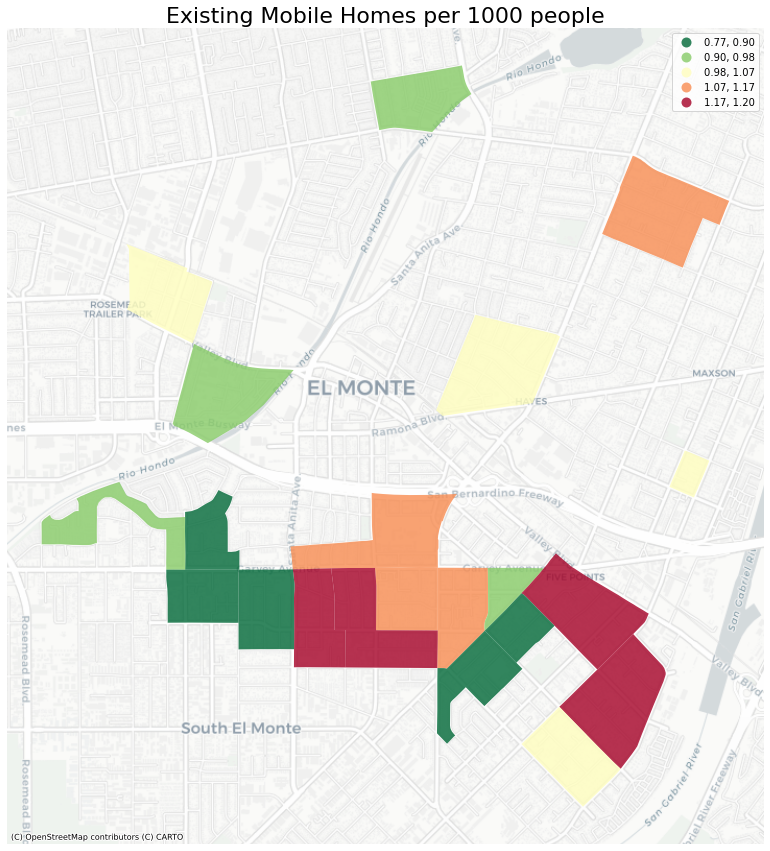

In [85]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
mhp.plot(ax=ax,
         figsize=(15,15),
         column='mh_per_1000_lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='quantiles')

ax.axis('off')
ax.set_title('Existing Mobile Homes per 1000 people',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

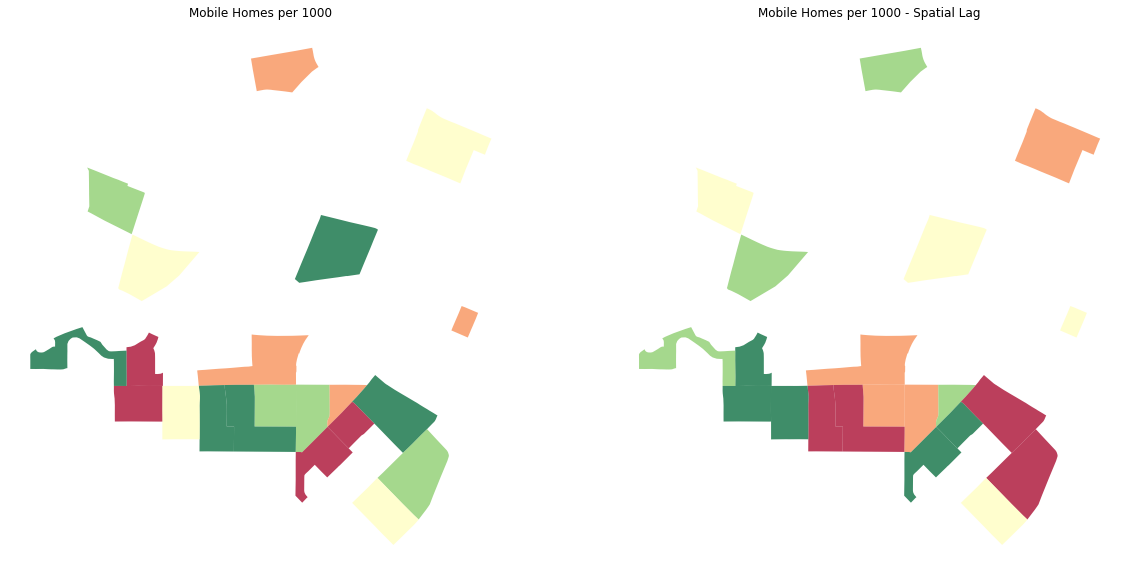

In [88]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
mhp.plot(ax=ax[0], # this assigns the map to the left subplot
         column='mh_per_1000', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Mobile Homes per 1000")

# spatial lag map on the right
mhp.plot(ax=ax[1], # this assigns the map to the right subplot
         column='mh_per_1000_lag', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Mobile Homes per 1000 - Spatial Lag")

plt.show()

**Interactive Map**

In [89]:
# interactive version needs to be in WGS84
mhp_web = mhp.to_crs('EPSG:4326')

In [90]:
# what's the centroid?
minx, miny, maxx, maxy = mhp_web.geometry.total_bounds
center_lat_mhp_web = (maxy-miny)/2+miny
center_lon_mhp_web = (maxx-minx)/2+minx

In [91]:
# some stats
mhp_web.mh_per_1000_lag.describe()

count    21.000000
mean      1.015997
std       0.134644
min       0.766693
25%       0.977039
50%       0.999828
75%       1.122567
max       1.198836
Name: mh_per_1000_lag, dtype: float64

In [94]:
# grab the median
median = mhp_web.mh_per_1000_lag.median()

In [96]:
fig = px.choropleth_mapbox(mhp_web, 
                     geojson=mhp_web.geometry, # the geometry column
                     locations=mhp_web.index, # the index
                     mapbox_style="satellite-streets",
                     zoom=9, 
                     color='mh_per_1000_lag',
                     color_continuous_scale='RdYlGn_r',
                     color_continuous_midpoint =median, # put the median as the midpoint
                     range_color =(0,median*2),
                     hover_data=['FIPS','TotalPop','MH SPACES','mh_per_1000','mh_per_1000_lag'],
                     center = {"lat": center_lat_mhp_web, "lon": center_lon_mhp_web},
                     opacity=0.8,
                     width=1000,
                     height=800,
                     labels={
                             'mh_per_1000_lag':'Mobile Homes per 1000 (Spatial Lag)',
                             'mh_per_1000':'Mobile Homes per 1000',
                     })
fig.update_traces(marker_line_width=0.1, marker_line_color='white')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

Whoops! I'll need to get Mapbox access- I will revisit this since I know my codes worked well. I'm intereted in creating a Moran's plot. 

**Moran's Plot**

Next, I will begin the process of qunatifying the degree of spatial autocorrelations. 

In [97]:
y = mhp.mh_per_1000
moran = Moran(y, wq)
moran.I

-0.17354767385278835

Seems like we have a negative autocorrelation. This means that similar values are far from each other. 

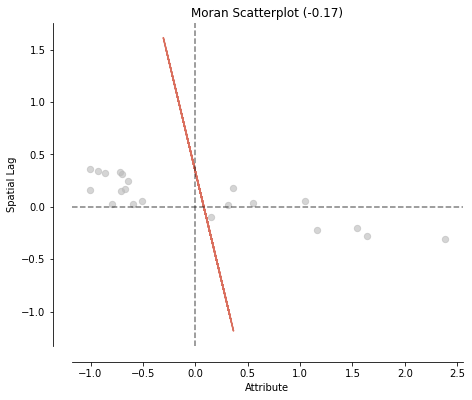

In [98]:
#let's put it in a scatterplot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: -0.17', ylabel='Density'>)

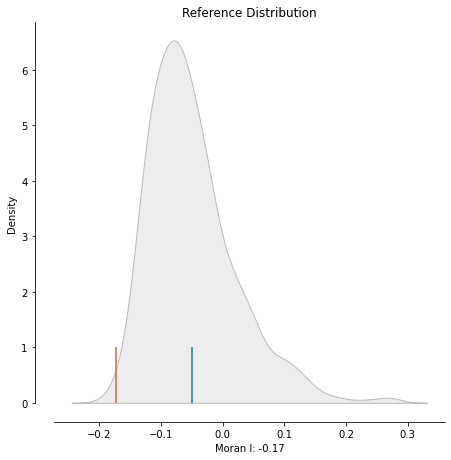

In [99]:
plot_moran_simulation(moran,aspect_equal=False)

In [100]:
moran.p_sim

0.004

We can see 0.004 < p-value 0.05. Considering how low our p-value is, we have strong evidence that there is no significant difference between mobile home locations and populations. 

**Local Spatial Autocorrelation- Moran Scatterplot**

In [101]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

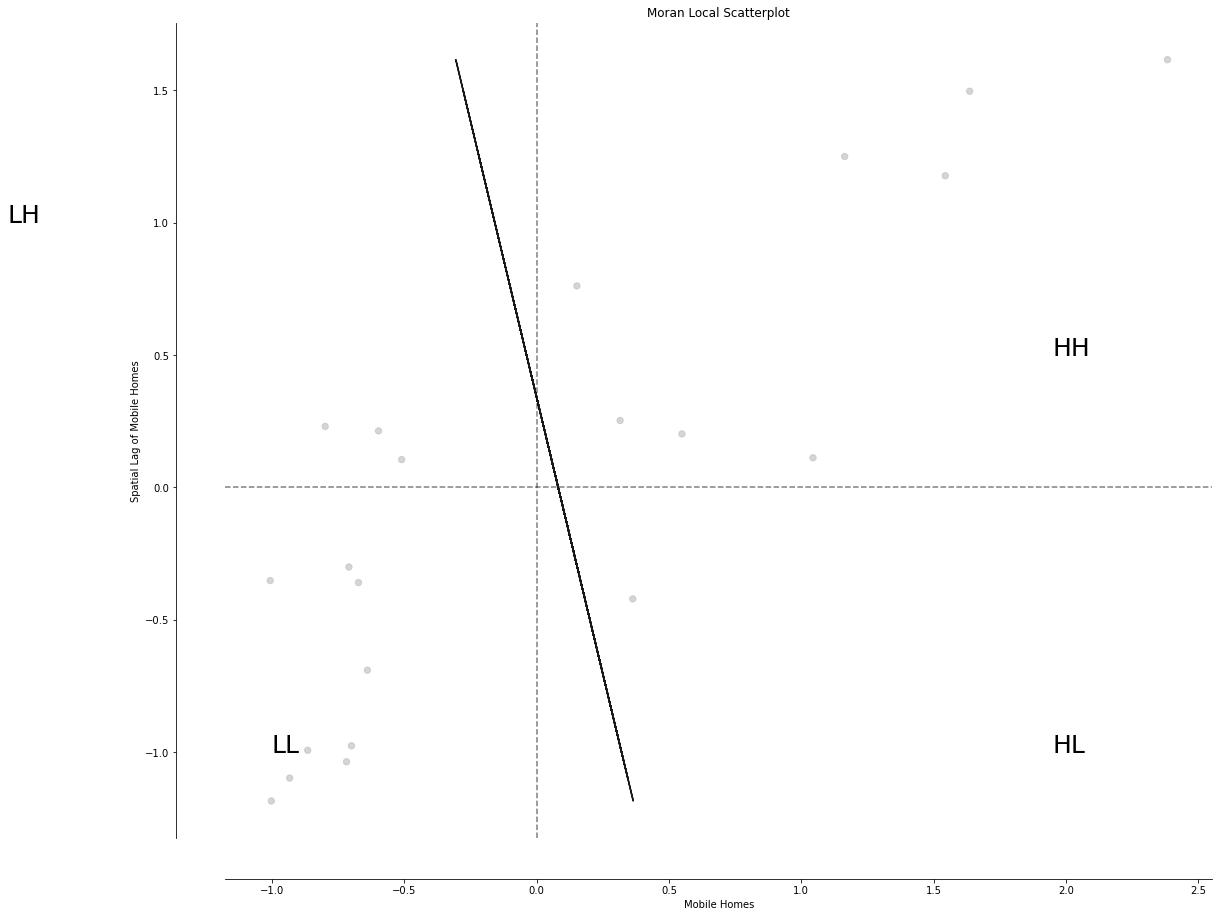

In [102]:
# Plot
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Mobile Homes")
ax.set_ylabel('Spatial Lag of Mobile Homes')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

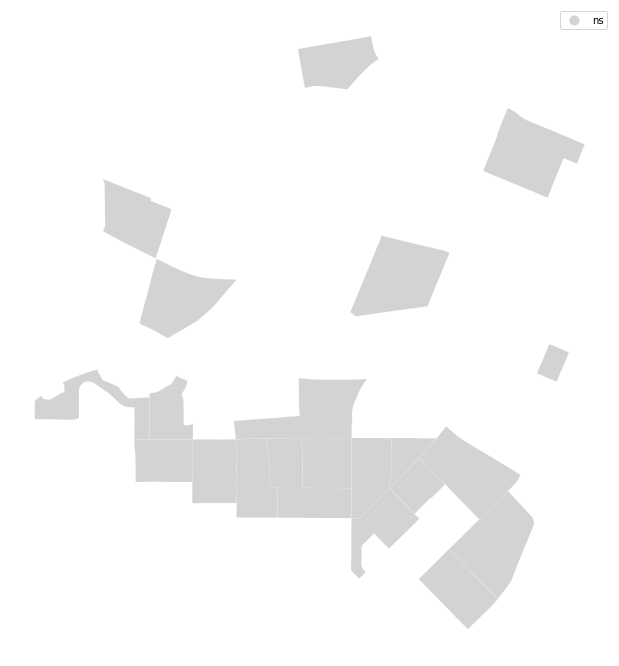

In [104]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, mhp, p=0.05, ax=ax)
plt.show()

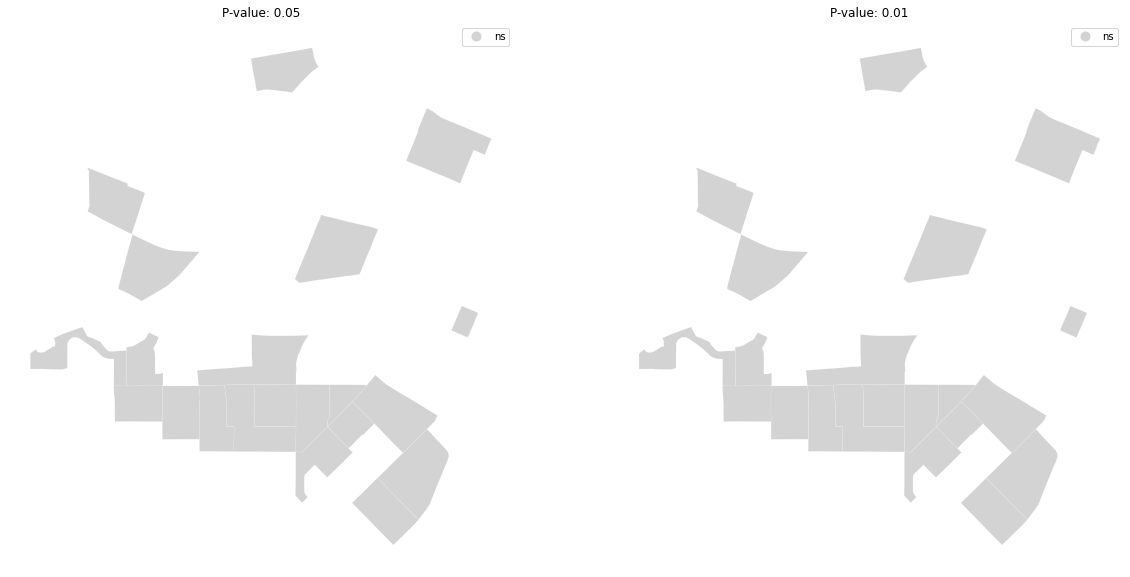

In [105]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa, mhp, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, mhp, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

we can see there are no statistically significantly clusters in El Monte, as we knew from the Moran's plot. While this analysis didn't present any patterns, it's will still be helpful for the analysis of this project as we continue to explore land uses and demographics. 